# **Taking fastai for a spin**

For the notebooks from BigData, we're going to use Google Colab, since we are going to be needing GPU power. If you prefer to run the notebooks on your local machine (via CPU, or GPU), make sure to make a new virtual environment, so you're not going to mess up your other environments. Just be warned: running these notebooks on CPU might take a while...

So, go to https://colab.research.google.com/, select the upload option, and upload this notebook.


When in Google Colab:

**First**, make sure you enable vGPU power from Colab: go to 'Runtime', 'Change runtime type', and select GPU. If you forget this step, training will take x10-x100 times longer...

**Second**: install all the latest versions and extra tools for fastai (see code block below). These are all bundeled in the fastbook project. Do this only once, so remember not to execute the cell below multiple times! 

When executing this in Colab, fastbook will ask you for an authorization key (API key) to access/mount your GDrive, so it can store data there. Just follow along with the provided information / link.

In [3]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

In [4]:
#add fast ai ssl certificate to avoid ssl error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


# **Computer Vision showcase**

## **Importing and prepping our data**
We're going to train a state of the art network in just a couple of lines of code, to really show off the awesome power of fastai abstractions. We'll train it on the Oxford Pet Dataset (7349 images of cats and dogs, from 37 different breeds). 
(Remember: from the 'AI Projects' course: in Keras, with our 'home made' CNN network, we got to a val_accuracy of around 80%, on the same dataset, but we had to download and extract it by hand). 
The dataset comes pre-installed with fastai, via de URLs.PETS link. We'll define a specific labelling function to determine if the image is a cat or a dog: in this dataset, it's determined with the **starting letter of the file**: is it a capital letter, than it's a cat. Otherwise it's a dog.

In [5]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()

Now that our data is extracted into memory, it's time to import it into our fastai framework. This is done with **dataloaders**. Our next notebook will cover the dataloader API, but I hope you can already figure it out, just be looking at the code...

In [6]:
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

## **Training a (pretrained) CNN model**

We'll be using a pre-trained network (resnet) to model this dataset. It's pretrained on 1.3 million (general purpose) images, so we'll use it's generic power to start from, and train our own model, using our own cats&dogs images. So, we'll use a pretrained resnet as a kind of backbone, and add our own classifier behind it. This will take less than a minute to finish, if you've remembered to add GPU support to your runtime. So, it will not retrain our backbone network, just our own added last layers.
When you watch the progress bar closely, you'll see 2 runs through the same progress bar.
First our own classifier network that we've placed behind the resnet backbone, will be trained. That's the first run. Then it will be validated (run the validation set through the trained network, to get accuracy). That's the second run. 

Then, to try to get even better performance, it's best practise to train your model even further, i.e. to train your entire model, including the backbone. So, we need to unfreeze (un-lock) the resnet backbone, and include that backbone part in the training phase as well, adjusting also those weights and biases. Luckily, fastai takes care of all of the above, in one simple command: the fine_tune function.

**Why you see two different accuracy reports**: one part is the training and validation with a frozen resnet backbone, and than a second part for the training/validation runs with the complete network.


**To be exact**: the fine_tune function that we'll be using here, performs 3 steps: a **fit_one_cycle, unfreeze, fit_one_cycle, and again a fit_one_cyle (because we'll be telling it to run 2 epochs in the 'unfrozen' training cycle)**. Furthermore, it will automatically choose a learning rate it thinks is best suited for the job, at that point / that batch of data that's being processed (that's the one_cycle bit). 


Don't worry, we'll dive into the details later.


See, if you can identify the different phases of training and validating, when you run the code block below. First, it will do a training run with a frozen backbone, followed by a validation run through this network. It will report the performance of this runs. Then, it will unfreeze the backbone, and give 2 runs of again a training- and validation runs, through this network, and print out the results of those.

In [7]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/charlesnanakwakye/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:06<00:00, 12.7MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.177175,0.029452,0.012179,03:08


epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

The model we've just created, should be pretty damn good! Almost perfect performance. We can check this by evaluating the training and validation loss, but also with the error_rate. This is the proportion of images that were incorrectly classified (i.e. '1 - accuracy'). Your model should reach **almost 0 error rate**! So, with just a few lines of code, we produced a model that outperformes the very, very, very best models from just a couple of years ago. I mean: the best models from the best researchers in the world at that time, with tons of resources, and compute at their disponsal... And we leave them in the dust, with just a couple of lines of code.
That's how fast deep learning is evolving. Models from a couple of years ago, are just ancient history...
But, still... these are numbers... 

## **Evaluating our CNN model**

The real proof of the pudding, is in the eating... so let's test our model, with a live example. Go fetch an image of a cat (from Google images or so), and save it to your computer. Then, execute the code below, asking you to upload an image.

When you've uploaded the image, execute the 2nd code block that loads the uploaded notebook into a PILImage, and runs it through the trained network (= doing inferencing)

In [ ]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(uploader.data[0])
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: False.
Probability it's a cat: 0.000001


We can also print out a couple of randomly selected images from our validation set, and see how our model predicted them (BTW: do you see the resemblance with the AI Project notebooks? ;-) )

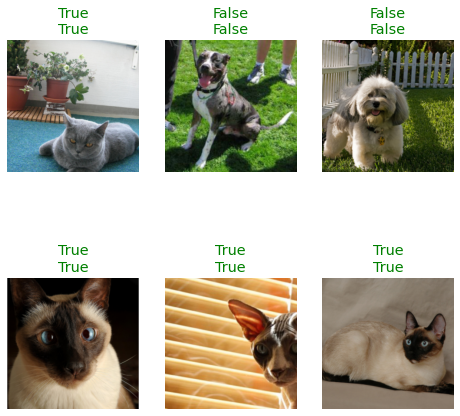

In [ ]:
learn.show_results(max_n=6, figsize=(8,8))

Let's dive a little deeper into the results, shall we? Let's create a confusion matrix for this classification function, and plot the top losses (the images where our model was wrong, ordered by the probability - how (un)sure our model was of its prediction).

This is like a very good sanity check, is our model 'good enough'? Could we do a better job as a human, or at least, can we determine or hint, as to why our model was wrong on these examples?

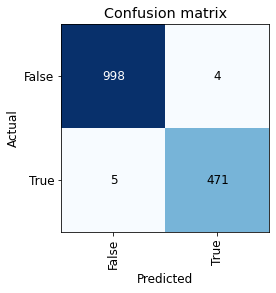

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

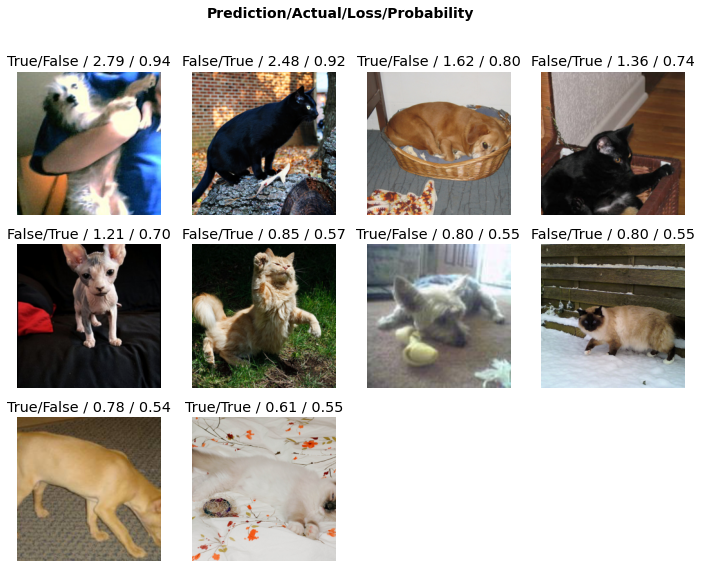

In [ ]:
interp.plot_top_losses(10)

Pretty neat, no?

***

# **Below are other use cases fastai can tackle: be warned: some will take a very long time to run!**
# **NLP showcase: warning: we'll be using HuggingFace in a couple of weeks - not the fastai NLP library**

One other area where deep learning has dramatically improved in the last couple of years is natural language processing (NLP). Computers can now generate text, translate automatically from one language to another, analyze comments, label words in sentences, and much more. 

Below you'll find all of the code necessary to train a model that can classify the **sentiment of a movie** review better than anything that existed in the world just five years ago. It uses a pre-trained Language Model (AWD_LSTM) - pretrained on WikiText, and then fine tunes this model with IMDB data to classify the sentiment. 

(BTW: we can even improve on this, by training a LM (LanguageModel) on our own data, so the IMDB data. The language used on WikiText is slightly different then on IMDB, so by first creating our own LM (still transferring the structure of AWD_LSTM, but training it ourself), and using this model as the basis for fine-tuning towards a classification model. This approach is called ULMFiT (Universal Language Model Fine Tuning). 

**Watch out: it will take a long time to run the code below (+- 30min)**

In [ ]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
# if CUDA runs out of memory, try changing / lowering the batch size: dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', bs=32)
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.605500,0.392492,0.822360,04:05


epoch,train_loss,valid_loss,accuracy,time
0,0.323593,0.265473,0.889320,08:15
1,0.252422,0.223745,0.907600,08:16
2,0.205627,0.182080,0.929120,08:16
3,0.154488,0.190899,0.926560,08:16


In [ ]:
# let's test our model - the numbers in the end are how sure our model is: first number probability of negative review, second number the probability of positive review

#learn.predict("I really liked this movie")
learn.predict("This was a crappy awefull performance")
#learn.predict("Awesome. Or not?")

('neg', TensorText(0), TensorText([0.8226, 0.1774]))

In [ ]:
# if you want to see the documentation
doc(learn.predict)

In [ ]:
# to check some sample reviews it trained on:
df = pd.read_csv(path/'texts.csv')
df.head()

For those who are curious, but be aware, ULMFit code below will run extremely long, probably around a couple of hours... 

In [ ]:
from fastai.text.all import *

# training our own Language Model
dls_lm = TextDataLoaders.from_folder(untar_data(URLs.IMDB), is_lm= True, valid_pct=0.1)
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.3).to_fp16()
learn.fine_tune(10)
learn.save_encoder('fine_tuned_enc')

dls_clas = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', text_vocab=dls_lm.vocab)
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

learn.load_encoder('fine_tuned_enc')
learn.fit_one_cycle(1, 2e-2)

# now you can freeze / unfreeze and fit_one_cycle to optimize classification some more!

epoch,train_loss,valid_loss,time
0,4.226233,3.993344,24:31


epoch,train_loss,valid_loss,time
0,4.075601,3.902428,26:45
1,4.011878,3.839036,26:38
2,3.933656,3.788014,26:17
3,3.892213,3.750376,26:12
4,3.848997,3.725111,26:21
5,3.812683,3.707879,26:10
6,3.787905,3.696387,25:58
7,3.762516,3.689577,26:08
8,3.753093,3.686749,26:34
9,3.743957,3.686251,26:51


AttributeError: ignored

# Next up: **Segmentation showcase**

The 'Next up showcases' you can see in the rest of this notebook, are just to give you an overview of what fastai can do. They're a little bit out of scope for the BigData course, because we'll be focussing on Computer Vision and NLP.


Creating a model that can recognize the content of every individual pixel in an image is called segmentation. This is important for instance for self driving cars: we have to be able to localize certain objects in a picture (for instance a pedestrian).

Here is how we can train a segmentation model with fastai, using a subset of the Camvid dataset (the data needs to be 'labelled', so every pixel needs to be 'colored in', belonging to a certain object, so we can train a model on it):

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,time
0,3.006836,2.274197,00:01


epoch,train_loss,valid_loss,time
0,1.693069,1.469104,00:02
1,1.457448,1.330149,00:02
2,1.353707,1.279210,00:02
3,1.265568,0.979036,00:02
4,1.137241,0.834280,00:02
5,1.031006,0.798724,00:02
6,0.941882,0.780172,00:02
7,0.872355,0.772490,00:02


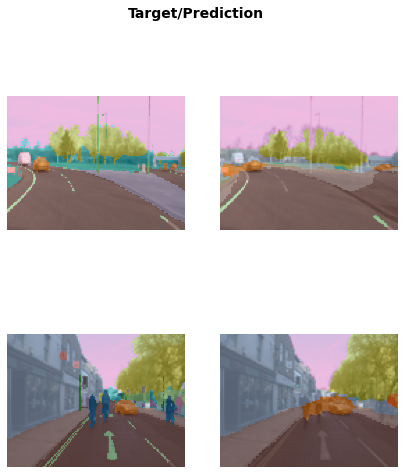

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

# Next up:  **Tabular showcase**

Deep learning can also be applied to structured, tabular data. But, this not so common. There is also no clear way to do some kind of transfer learning, because tabular data can be almost anything. No transfer learning also means, no fine_tuning. That's why we use the 'fit_one_cycle' directly, for fitting, aka training, our model.

Ofcourse, when dealing with tabular data, we have to tell the model which parameters/columns, are continuous, (cat_names) and which ones are categorical . 

And we also need to do some (pre) processing, proc: 
* Categorify is going to take every categorical variable and make a map from 
integer to unique categories, then replace the values by the corresponding index.

* FillMissing will fill the missing values in the continuous variables by the median of existing values (you can choose a specific value if you prefer)

* Normalize will normalize the continuous variables (substract the mean and divide by the std)

So, let's use the Adult dataset, which contains some demographic data about individuals (see the dataframe below), and we'll try to predict the salary using that info.



In [ ]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])


learn = tabular_learner(dls, metrics=accuracy)

learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.371018,0.358754,0.833077,00:05
1,0.342535,0.354308,0.837377,00:05
2,0.334035,0.350416,0.839220,00:05


In [ ]:
df = pd.read_csv(path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


# Next up: **Recommender showcase**

We'll use the MovieLens dataset for this one, and ofcourse we'll use a deep collaboration approach to recommending (see 'AI Projects course').
Here we'll train a model to predict movie ratings from 0.5-5.5

In [ ]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)


epoch,train_loss,valid_loss,time
0,1.510746,1.341117,00:00


epoch,train_loss,valid_loss,time
0,1.357941,1.281502,00:00
1,1.263487,1.104863,00:00
2,1.029392,0.818524,00:00
3,0.807070,0.686649,00:00
4,0.699629,0.651221,00:00
5,0.657426,0.637935,00:00
6,0.636094,0.632872,00:00
7,0.631084,0.629495,00:00
8,0.617359,0.628005,00:00
9,0.614851,0.627857,00:00


In [ ]:
df = pd.read_csv(path/'ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [ ]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,36.0,46.0,3.0,3.406943
1,46.0,97.0,3.5,3.057547
2,59.0,15.0,5.0,4.350379
3,84.0,20.0,2.0,3.720597
4,30.0,75.0,4.0,4.267234
5,57.0,18.0,4.0,3.907611
6,28.0,71.0,4.0,2.974756
7,53.0,82.0,5.0,4.376732
8,31.0,76.0,4.0,3.916768
